# Neural style transfer

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>



<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now, what would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

#1) Importing Necessary Libraries and Configurations
Imports essential libraries like TensorFlow, NumPy, Matplotlib, and PIL for deep learning, numerical operations, and image processing. It also configures Matplotlib for better visualization and sets an environment variable for TensorFlow Hub model loading.

In [1]:
import os  # Import the OS module to interact with the operating system
import tensorflow as tf  # Import TensorFlow for deep learning tasks

# Set an environment variable to load TensorFlow Hub models in compressed format
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Import display module from IPython to display images in Jupyter notebooks
import IPython.display as display

# Import Matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure Matplotlib parameters for better visualization
mpl.rcParams['figure.figsize'] = (12, 12)  # Set the default figure size
mpl.rcParams['axes.grid'] = False  # Disable grid lines on plots

# Import NumPy for numerical operations
import numpy as np

# Import PIL (Pillow) to handle image processing tasks
import PIL.Image

# Import time module for performance measurement
import time

# Import functools to work with higher-order functions
import functools


Specifying File Paths and Loading Images in Google Colab

In [2]:
# Provide the correct local file paths in Google Colab
content_path = "/content/ct2.jpg"  # Path to the content image
style_path = "/content/st13.jpg"  # Path to the style image

# Load images using TensorFlow's image utility
content_image = tf.keras.utils.load_img(content_path)  # Load content image
style_image = tf.keras.utils.load_img(style_path)  # Load style image

# Image Preprocessing and Resizing
This function, `load_img`, reads an image file, decodes it into an RGB format, and normalizes its pixel values to a range of [0,1]. It then resizes the image while maintaining its aspect ratio, ensuring the longest dimension does not exceed 512 pixels. Finally, it adds a batch dimension, making the image suitable for deep learning models.

In [3]:
def load_img(path_to_img):
    max_dim = 512  # Define the maximum dimension for resizing
    img = tf.io.read_file(path_to_img)  # Read the image file
    img = tf.image.decode_image(img, channels=3)  # Decode the image into RGB format
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize pixel values to [0,1]

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  # Get image dimensions
    long_dim = max(shape)  # Find the longest side
    scale = max_dim / long_dim  # Calculate the scaling factor

    new_shape = tf.cast(shape * scale, tf.int32)  # Compute new dimensions

    img = tf.image.resize(img, new_shape)  # Resize the image
    img = img[tf.newaxis, :]  # Add a batch dimension
    return img  # Return the processed image tensor

# Function to Visualize Images Using Matplotlib
The `imshow` function takes an image tensor as input and displays it using Matplotlib. If the image has a batch dimension, it removes it before visualization. An optional title can be provided to label the displayed image.









In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:  # Check if image has batch dimension
        image = tf.squeeze(image, axis=0)  # Remove batch dimension

    plt.imshow(image)  # Display the image
    if title:
        plt.title(title)  # Set the title if provided

# Loading and Displaying Content and Style Images
Loads the content and style images using the `load_img` function and displays them side by side using Matplotlib subplots. The imshow function is used to render each image with appropriate titles for better visualization.

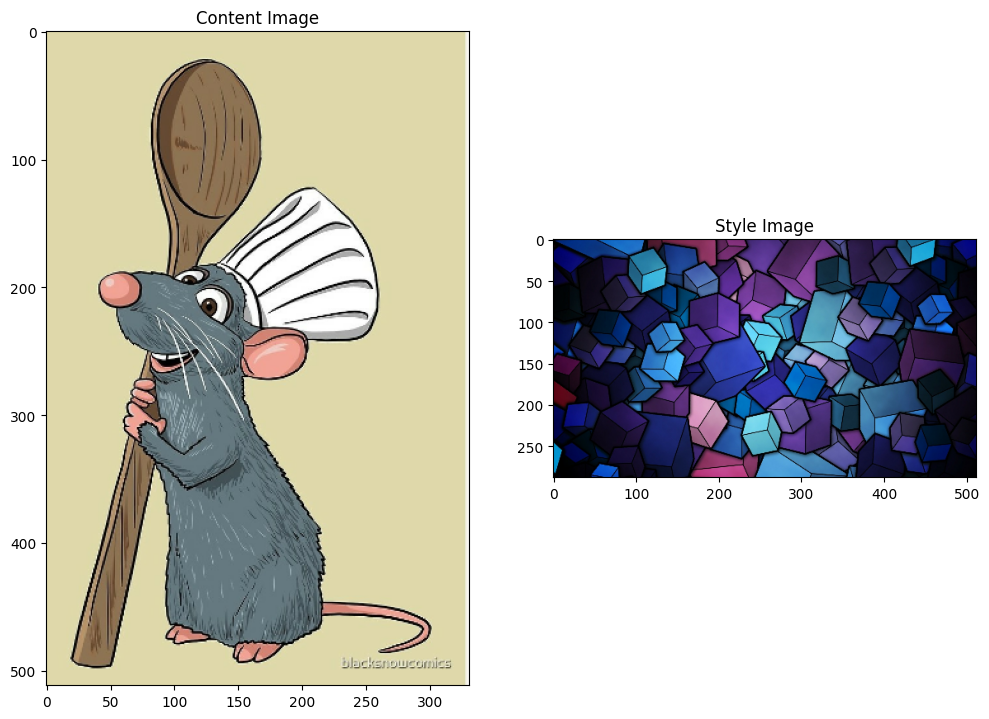

In [5]:
# Load and display content and style images
content_image = load_img(content_path)  # Load the content image
style_image = load_img(style_path)  # Load the style image

plt.subplot(1, 2, 1)  # Create subplot for content image
imshow(content_image, 'Content Image')  # Display content image

plt.subplot(1, 2, 2)  # Create subplot for style image
imshow(style_image, 'Style Image')  # Display style image

# Converting a Tensor to an Image
#### **Explanation:**
This function, `tensor_to_image`, converts a TensorFlow tensor into a displayable image. It scales the pixel values from the range [0,1] to [0,255], converts the tensor to a NumPy array, and ensures that any extra batch dimension is removed. Finally, it creates and returns a `PIL` image for easy visualization and saving.

In [6]:
# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor * 255  # Scale tensor values from [0,1] to [0,255]
    tensor = np.array(tensor, dtype=np.uint8)  # Convert tensor to a NumPy array with uint8 type
    if np.ndim(tensor) > 3:  # Check if the tensor has more than 3 dimensions
        assert tensor.shape[0] == 1  # Ensure the first dimension is 1 (batch size)
        tensor = tensor[0]  # Remove the batch dimension
    return PIL.Image.fromarray(tensor)  # Convert NumPy array to PIL Image


# Using a Pre-trained Model to Stylize the Content Image
#### **Explanation:**
Loads a pre-trained neural style transfer model from TensorFlow Hub and applies it to the content image using the specified style image. The model processes both images and generates a stylized output. The resulting tensor is then converted into a displayable image using the `tensor_to_image` function.

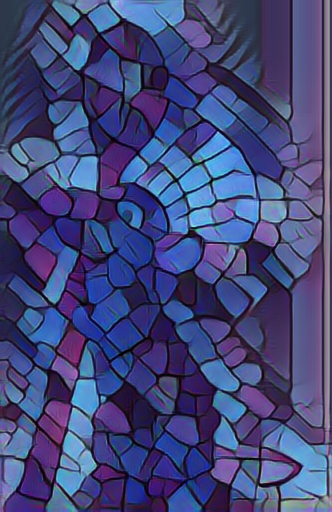

In [7]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub  # Import TensorFlow Hub

# Load pre-trained style transfer model from TensorFlow Hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Apply style transfer to the content image using the style image
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

# Convert the output tensor to an image and display it
tensor_to_image(stylized_image)


# Preprocessing and Classifying Image Using VGG19
#### **Explanation:**
 Preprocesses the content image to match the input requirements of the VGG19 model by scaling pixel values and resizing it to 224x224 pixels. It then loads a pre-trained VGG19 model with ImageNet weights and predicts classification probabilities for the processed image. Finally, it displays the shape of the prediction output.

In [8]:
# Preprocess content image for VGG19 model
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)  # Scale image to match VGG19 input requirements
x = tf.image.resize(x, (224, 224))  # Resize image to 224x224 pixels (VGG19 input size)

# Load pre-trained VGG19 model with ImageNet weights
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

# Get prediction probabilities for the processed image
prediction_probabilities = vgg(x)

# Display the shape of the prediction probabilities
prediction_probabilities.shape

TensorShape([1, 1000])

# Extracting the Most Likely Classes and Their Probabilities
#### **Explanation:**
Decodes the top 5 predicted classes from the VGG19 model’s output probabilities. It retrieves the class names and their respective probabilities, providing insight into what the model identifies in the processed image.

In [9]:
# Decode the top 5 predictions from VGG19 model
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]

# Extract class names and their respective probabilities
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('electric_fan', np.float32(0.19303878)),
 ('hair_slide', np.float32(0.055414215)),
 ('lycaenid', np.float32(0.040521417)),
 ('comic_book', np.float32(0.037241552)),
 ('envelope', np.float32(0.035953812))]

# **Loading VGG19 Model and Displaying Layer Names**  

#### **Explanation:**  
This loads the VGG19 model from TensorFlow Keras without the top classification layer (`include_top=False`) and initializes it with pre-trained ImageNet weights. It then iterates through the model’s layers and prints their names for reference. A blank line is printed for better readability.


In [10]:
# Load VGG19 model without the top classification layer
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Print an empty line for better readability
print()

# Iterate through the layers of the VGG19 model and print their names
for layer in vgg.layers:
    print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


# **Defining Content and Style Layers for Loss Calculation**  

#### **Explanation:**  
This specifies the layers of the VGG19 model to be used for computing content and style loss in a neural style transfer task.  

- The **content layer** is set to `'block5_conv2'`, which captures high-level features from the content image.  
- The **style layers** include the first convolutional layer from each of the five blocks (`'block1_conv1'` to `'block5_conv1'`), which help in capturing the style features.  
- The number of content and style layers is then calculated for later use in the loss computation.


In [11]:
# Define the content layer to be used for content loss
content_layers = ['block5_conv2']  # Select the second convolutional layer of block 5

# Define the style layers to be used for style loss
style_layers = ['block1_conv1',  # First convolutional layer of block 1
                'block2_conv1',  # First convolutional layer of block 2
                'block3_conv1',  # First convolutional layer of block 3
                'block4_conv1',  # First convolutional layer of block 4
                'block5_conv1']  # First convolutional layer of block 5

# Get the number of content and style layers
num_content_layers = len(content_layers)  # Count the number of content layers
num_style_layers = len(style_layers)  # Count the number of style layers

# **Creating a VGG Model for Extracting Intermediate Layer Outputs**  

#### **Explanation:**  
This function, `vgg_layers(layer_names)`, constructs a modified VGG19 model that extracts outputs from specified intermediate layers.  

- It loads the **pre-trained VGG19 model** without the fully connected (top) layers (`include_top=False`).  
- The model parameters are **frozen** (`trainable = False`) to prevent training.  
- The function retrieves the outputs of the specified layers and creates a **new model** that takes the original VGG19 input but returns only these selected outputs.  
- This model is useful for extracting **content and style features** in tasks like neural style transfer.  


In [12]:
def vgg_layers(layer_names):
    """Creates a VGG model that returns a list of intermediate output values."""

    # Load the pre-trained VGG19 model without the fully connected (top) layers
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # Freeze the model parameters to prevent training
    vgg.trainable = False

    # Extract outputs from specified intermediate layers
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Create a new model that takes the same input as VGG19 and outputs selected layers
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

    return model

# **Extracting and Analyzing Style Features from VGG19**  

#### **Explanation:**  
Extracts and analyzes style features from the specified style layers using the VGG19 model.  

- A **style feature extractor** (`style_extractor`) is created using the `vgg_layers` function with the predefined `style_layers`.  
- The **style image** is processed by scaling pixel values back to the range **[0, 255]** before being passed through the extractor.  
- The extracted feature maps for each style layer are analyzed, printing their **shape, minimum, maximum, and mean values** to observe the feature statistics.  


In [13]:
# Extract features from the specified style layers
style_extractor = vgg_layers(style_layers)

# Process the style image (scale pixel values back to [0, 255])
style_outputs = style_extractor(style_image * 255)

# Print statistics for each style layer output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)  # Shape of the feature map
    print("  min: ", output.numpy().min())   # Minimum value in the feature map
    print("  max: ", output.numpy().max())   # Maximum value in the feature map
    print("  mean: ", output.numpy().mean()) # Mean value of the feature map
    print()

block1_conv1
  shape:  (1, 288, 512, 64)
  min:  0.0
  max:  677.5651
  mean:  22.620247

block2_conv1
  shape:  (1, 144, 256, 128)
  min:  0.0
  max:  4087.7468
  mean:  135.2569

block3_conv1
  shape:  (1, 72, 128, 256)
  min:  0.0
  max:  7223.3706
  mean:  182.61528

block4_conv1
  shape:  (1, 36, 64, 512)
  min:  0.0
  max:  20321.53
  mean:  617.5071

block5_conv1
  shape:  (1, 18, 32, 512)
  min:  0.0
  max:  3029.9941
  mean:  52.39685



# **Computing the Gram Matrix for Style Representation**  

#### **Explanation:**  
This function, `gram_matrix(input_tensor)`, calculates the **Gram matrix**, which captures the correlations between feature maps and is used to represent style in neural style transfer.  

- The **Gram matrix** is computed using **Einstein summation (`einsum`)**, which performs a dot product across feature maps.  
- The shape of the input tensor is obtained to determine the **number of spatial locations** (height × width).  
- The result is **normalized** by dividing by the number of spatial locations to ensure consistent style representation regardless of image size.  


In [14]:
def gram_matrix(input_tensor):
    """Computes the Gram matrix for style representation."""
    # Compute the dot product of the feature maps with itself using Einstein summation
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # Get the shape of the input tensor
    input_shape = tf.shape(input_tensor)

    # Compute the scaling factor (number of spatial locations)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    # Normalize the Gram matrix by the number of locations
    return result / num_locations

# **Building a Model to Extract Style and Content Features**  

#### **Explanation:**  
The `StyleContentModel` class extends `tf.keras.models.Model` to extract both **style** and **content** features from an input image using a modified VGG19 model.  

- The **VGG19 model** is loaded with both style and content layers, and its weights are frozen to prevent training.  
- The input image is **scaled to [0,255]** and preprocessed using VGG19's preprocessing function.  
- The extracted feature maps are **split** into style and content outputs.  
- The **Gram matrix** is computed for the style features to capture style representation.  
- Finally, the model returns a **dictionary** containing extracted style and content features.  


In [15]:
class StyleContentModel(tf.keras.models.Model):
    """A model to extract and compute style and content features."""
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()

        # Load VGG model with both style and content layers
        self.vgg = vgg_layers(style_layers + content_layers)

        # Store layer names
        self.style_layers = style_layers
        self.content_layers = content_layers

        # Number of style layers
        self.num_style_layers = len(style_layers)

        # Freeze VGG model to prevent training
        self.vgg.trainable = False

    def call(self, inputs):
        """Computes style and content features from the input image."""

        # Scale input image back to [0,255]
        inputs = inputs * 255.0

        # Preprocess input image using VGG19 preprocessing
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        # Get feature maps from VGG
        outputs = self.vgg(preprocessed_input)

        # Split style and content outputs
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Compute Gram matrix for style features
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Create dictionary for content features
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        # Create dictionary for style features
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


# **Extracting and Analyzing Style and Content Features**  

#### **Explanation:**  
It uses the `StyleContentModel` to extract and analyze **style** and **content** features from the content image.  

- A **feature extractor** (`extractor`) is created using the predefined **style and content layers**.  
- The **content image** is converted into a tensor and passed through the extractor to obtain feature maps.  
- The extracted **style features** are displayed, including their **shape, minimum, maximum, and mean values**.  
- Similarly, the extracted **content features** are analyzed, providing insights into the feature representations of the input image.  


In [16]:
# Assuming StyleContentModel is defined elsewhere to extract style and content features
extractor = StyleContentModel(style_layers, content_layers)

# Convert content image to a tensor and pass it through the model
results = extractor(tf.constant(content_image))

# Print extracted style features
print('Styles:')
for name, output in sorted(results['style'].items()):  # Loop through style features
    print("  ", name)  # Layer name
    print("    shape: ", output.numpy().shape)  # Shape of the extracted features
    print("    min: ", output.numpy().min())  # Minimum value
    print("    max: ", output.numpy().max())  # Maximum value
    print("    mean: ", output.numpy().mean())  # Mean value
    print()

# Print extracted content features
print("Contents:")
for name, output in sorted(results['content'].items()):  # Loop through content features
    print("  ", name)  # Layer name
    print("    shape: ", output.numpy().shape)  # Shape of the extracted features
    print("    min: ", output.numpy().min())  # Minimum value
    print("    max: ", output.numpy().max())  # Maximum value
    print("    mean: ", output.numpy().mean())  # Mean value

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.11951917
    max:  65217.754
    mean:  653.0107

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  226762.94
    mean:  27030.344

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  998716.4
    mean:  34860.42

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  10175731.0
    mean:  338252.66

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  151016.72
    mean:  2658.298

Contents:
   block5_conv2
    shape:  (1, 32, 20, 512)
    min:  0.0
    max:  1840.8695
    mean:  17.47423


# **Extracting Target Style and Content Features from Images**  

#### **Explanation:**  
It extracts the **style** and **content** features from the respective images using the `StyleContentModel`.  

- `style_targets` stores the extracted **style features** from the **style image**.  
- `content_targets` stores the extracted **content features** from the **content image**.  
- These extracted features serve as **targets** for the neural style transfer process, guiding the optimization to match the style and content during image transformation.  


In [17]:
# Extract style and content features from the images
style_targets = extractor(style_image)['style']  # Style features from style image
content_targets = extractor(content_image)['content']  # Content features from content image

# **Initializing the Image for Optimization**  

#### **Explanation:**  
This creates a **TensorFlow variable** to store the image that will be optimized during neural style transfer.  

- The `image` variable is initialized with the **content image**, meaning the transformation starts from this image.  
- Since `tf.Variable` allows for gradient updates, this variable will be **iteratively adjusted** to blend the content and style features through optimization.  


In [18]:
# Create a TensorFlow variable for the image that will be optimized
image = tf.Variable(content_image)  # The image starts as the content image

# **Clipping Image Pixel Values to [0,1] Range**  

#### **Explanation:**  
This function, `clip_0_1(image)`, ensures that pixel values remain within a **valid range** after updates during neural style transfer.  

- It uses `tf.clip_by_value()` to **restrict** all pixel values between **0.0 and 1.0**.  
- This prevents artifacts that may arise due to pixel values going **out of bounds** during optimization.  
- Maintaining this range ensures that the processed image remains **visually interpretable** and suitable for display.  


In [19]:
import tensorflow as tf

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


# **Defining an Optimizer for Image Optimization**  

#### **Explanation:**  
This initializes an **Adam optimizer** to update the image during the neural style transfer process.  

- **`learning_rate=0.02`**: Determines the step size for each update, affecting convergence speed.  
- **`beta_1=0.99`**: A momentum parameter that helps smooth updates and stabilize training.  
- **`epsilon=1e-1`**: A small constant to prevent division by zero and improve numerical stability.  

This optimizer will be used to iteratively refine the image to blend content and style features effectively.  


In [20]:
# Define an optimizer for updating the image during optimization
opt = tf.keras.optimizers.Adam(
    learning_rate=0.02,  # Controls how much the image updates in each step
    beta_1=0.99,         # Smoothing parameter for momentum-based updates
    epsilon=1e-1         # Small constant to improve numerical stability
)


# **Setting Weights for Style and Content Loss**  

#### **Explanation:**  
These weights control the **balance** between style and content loss during neural style transfer.  

- **`style_weight = 1e-2`**: A lower weight means the style features have **less influence** on the final image.  
- **`content_weight = 1e4`**: A higher weight ensures the **content structure** is preserved more strongly.  

By adjusting these values, we can control how much the generated image **resembles the content image** versus how much it **adopts the artistic style** of the style image.  


In [21]:
# Define weights to balance style and content loss
style_weight = 1e-2
content_weight = 1e4


# **Computing Style and Content Loss**  

#### **Explanation:**  
The `style_content_loss(outputs)` function calculates the **total loss** by combining **style loss** and **content loss**, which guides the optimization process in neural style transfer.  

- **Style Loss**:  
  - Computed using **Mean Squared Error (MSE)** between extracted and target **style features**.  
  - Normalized by the number of style layers and weighted by `style_weight`.  

- **Content Loss**:  
  - Computed using **MSE** between extracted and target **content features**.  
  - Normalized by the number of content layers and weighted by `content_weight`.  

- **Total Loss**:  
  - The sum of style and content loss ensures the optimized image **preserves content structure** while **adopting the desired style**.  


In [22]:
def style_content_loss(outputs):

    # Extract style and content outputs from the model
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Compute style loss using Mean Squared Error (MSE) for each style layer
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers  # Normalize by number of style layers

    # Compute content loss using Mean Squared Error (MSE) for each content layer
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers  # Normalize by number of content layers

    # Total loss is the sum of style and content loss
    loss = style_loss + content_loss
    return loss


# **Performing a Single Training Step for Neural Style Transfer**  

#### **Explanation:**  
The `train_step(image)` function performs one iteration of optimizing the image using **style and content loss**.  

- Uses **TensorFlow's `GradientTape`** to track computations for automatic differentiation.  
- Extracts **style and content features** from the current image using `extractor(image)`.  
- Computes the **total loss** using `style_content_loss(outputs)`.  
- Computes **gradients** of the loss with respect to the image.  
- Updates the image using the **Adam optimizer (`opt.apply_gradients`)**.  
- Ensures pixel values remain **within [0,1]** using `clip_0_1(image)`.  

This function is **decorated with `@tf.function()`** to enable **graph execution**, improving performance.  


In [23]:
import tensorflow as tf

@tf.function()
def train_step(image):

    with tf.GradientTape() as tape:
        outputs = extractor(image)  # Get style and content features from the image
        loss = style_content_loss(outputs)  # Compute the total loss

    # Compute gradients of the loss with respect to the image
    grad = tape.gradient(loss, image)

    # Apply the gradients to update the image
    opt.apply_gradients([(grad, image)])

    # Ensure pixel values stay in the range [0,1]
    image.assign(clip_0_1(image))


# **Updating the Image and Displaying the Final Result**  

#### **Explanation:**  
This code performs **three training steps** to refine the image using the **train_step function** and then displays the optimized result.  

- Calls `train_step(image)` **three times** to iteratively update the image using **style and content loss**.  
- Converts the final optimized image tensor to a **displayable image** using `tensor_to_image(image)`.  

Each training step brings the image **closer to the target style** while preserving the **content structure**.  


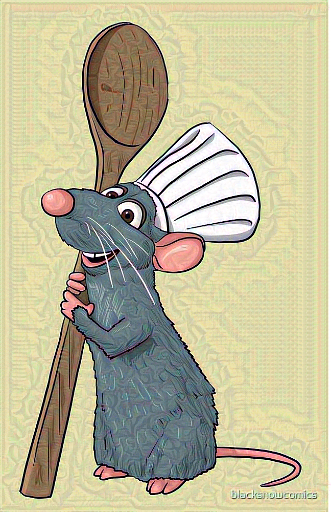

In [24]:
# Perform three training steps to update the image
train_step(image)  # First update
train_step(image)  # Second update
train_step(image)  # Third update

# Convert the final optimized image tensor to a displayable image
tensor_to_image(image)

### **Training the Image Using Neural Style Transfer**  

#### **Explanation:**  
This implements the **training loop** for neural style transfer, optimizing the image over multiple **epochs** and **steps per epoch**.  

- Uses `train_step(image)` to **iteratively update** the image.  
- Displays real-time progress using **dots (`.`)** for each training step.  
- Dynamically **updates the displayed image** using `IPython.display`.  
- Tracks and prints the **total training time**.  

This process gradually refines the image, blending **content structure** with the desired **artistic style**.  


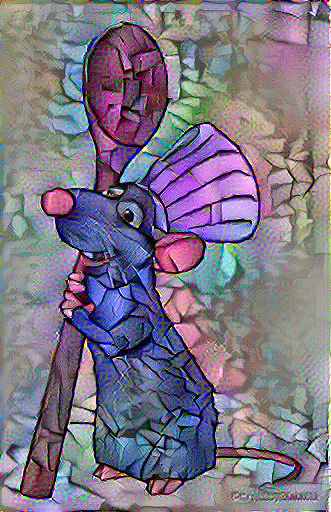

Train step: 1000
Total time: 66.5 seconds


In [25]:
import time
from IPython import display  # Used for updating the output in Jupyter notebooks

# Start timer to measure training time
start = time.time()

# Define training parameters
epochs = 10              # Number of times to go through the dataset
steps_per_epoch = 100    # Number of optimization steps per epoch

step = 0  # Counter for total steps

# Training loop
for n in range(epochs):  # Loop over epochs
    for m in range(steps_per_epoch):  # Loop over steps in each epoch
        step += 1
        train_step(image)  # Update the image using gradient descent
        print(".", end='', flush=True)  # Print progress dots without a new line

    # Clear previous output and display the updated image
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))

    print("Train step: {}".format(step))  # Print current step count

# Measure total training time
end = time.time()
print("Total time: {:.1f} seconds".format(end - start))


# **Applying a High-Pass Filter to Detect Edges**  

#### **Explanation:**  
The `high_pass_x_y(image)` function applies a **high-pass filter** to highlight **edges and fine details** in an image.  

- **Detects abrupt changes in pixel values**, capturing **sharp edges** and **texture details**.  
- **Computes differences between adjacent pixels** in:  
  - **X-direction (`x_var`)**: Highlights vertical edges.  
  - **Y-direction (`y_var`)**: Highlights horizontal edges.  

This function is useful for **preserving structural details** during neural style transfer.  


In [26]:
def high_pass_x_y(image):
    """
    Computes the high-pass filter response in the x and y directions.

    Parameters:
    image (tf.Tensor): A 4D image tensor (batch, height, width, channels).

    Returns:
    x_var (tf.Tensor): High-pass filtered image in the x-direction.
    y_var (tf.Tensor): High-pass filtered image in the y-direction.
    """

    # Compute the difference between adjacent pixels along the width (x-direction)
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]

    # Compute the difference between adjacent pixels along the height (y-direction)
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var


# **Visualizing Edge Detection with High-Pass Filtering**  

#### **Explanation:**  
This applies a **high-pass filter** to detect edges in both the **original content image** and the **styled image**, then visualizes the results.  

- Uses `high_pass_x_y(image)` to extract **horizontal and vertical edges**.  
- **Displays edge maps** for both the original and styled images:  
  - **Top row**: Horizontal and vertical edges of the **original content image**.  
  - **Bottom row**: Horizontal and vertical edges of the **styled image**.  
- Uses `clip_0_1(2 * deltas + 0.5)` to normalize the filtered images for visualization.  

This comparison helps analyze **how much fine detail and structure** are retained during neural style transfer.  


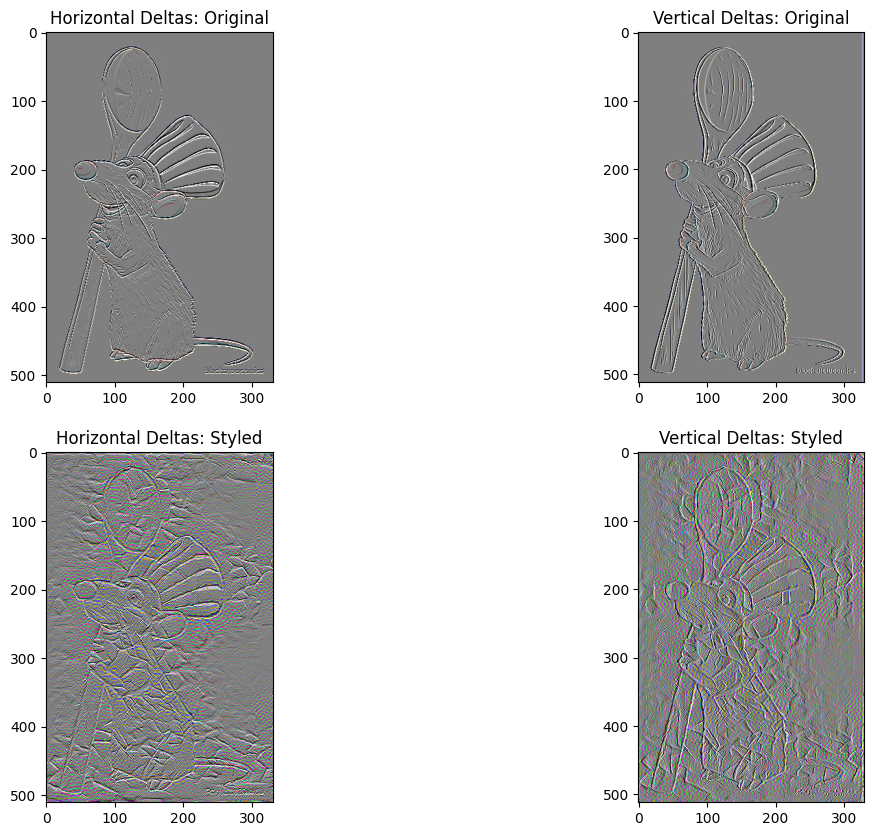

In [27]:
# Compute high-pass filtered versions (edge detection) for the content image
x_deltas, y_deltas = high_pass_x_y(content_image)

# Create a figure to visualize the high-pass filtered images
plt.figure(figsize=(14, 10))

# Plot horizontal edges of the original content image
plt.subplot(2, 2, 1)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Original")

# Plot vertical edges of the original content image
plt.subplot(2, 2, 2)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Original")

# Compute high-pass filtered versions for the styled image (updated image)
x_deltas, y_deltas = high_pass_x_y(image)

# Plot horizontal edges of the styled image
plt.subplot(2, 2, 3)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Styled")

# Plot vertical edges of the styled image
plt.subplot(2, 2, 4)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Styled")


# **Applying and Visualizing Sobel Edge Detection**  

#### **Explanation:**  
This applies **Sobel edge detection** to the **content image** and visualizes the detected edges.  

- Uses `tf.image.sobel_edges(content_image)` to compute:  
  - **Horizontal Sobel edges** (gradient along the x-axis).  
  - **Vertical Sobel edges** (gradient along the y-axis).  
- **Displays results in two subplots**:  
  - **Left**: Horizontal Sobel edges.  
  - **Right**: Vertical Sobel edges.  
- **Normalization (`clip_0_1(sobel[..., 0] / 4 + 0.5)`)** ensures values are in the range [0,1] for visualization.  

Sobel edge detection is useful for **highlighting contours and structural details** in an image.  


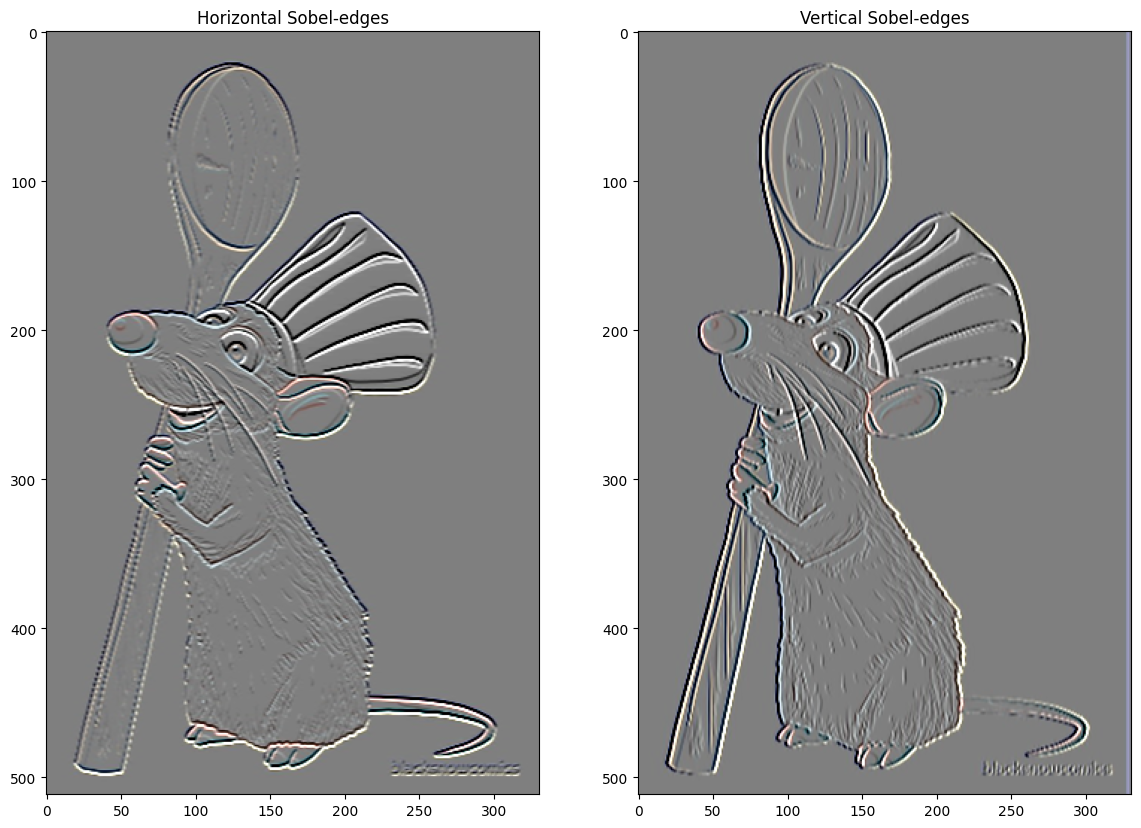

In [28]:
# Create a figure to visualize Sobel edge detection results
plt.figure(figsize=(14, 10))

# Apply Sobel edge detection to the content image
sobel = tf.image.sobel_edges(content_image)  # Shape: (H, W, C, 2)

# Plot horizontal Sobel edges
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0] / 4 + 0.5), "Horizontal Sobel-edges")

# Plot vertical Sobel edges
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1] / 4 + 0.5), "Vertical Sobel-edges")


# **Implementing Total Variation Loss for Image Smoothness**  

#### **Explanation:**  
This function computes **Total Variation (TV) loss**, which encourages **spatial smoothness** in the generated image.  

- **Why?** Reduces **unwanted noise and artifacts**, making the image more visually appealing.  
- **How?**  
  1. Uses `high_pass_x_y(image)` to compute **differences between adjacent pixels** in both x and y directions.  
  2. Computes the **absolute sum** of these differences to measure roughness.  
  3. A **lower loss value** indicates a **smoother image**.  

This regularization technique helps maintain **natural transitions** in the stylized image.  


In [29]:
import tensorflow as tf

def total_variation_loss(image):
    """
    Computes the Total Variation (TV) loss to encourage spatial smoothness in the image.

    Parameters:
    image (tf.Tensor): A 4D image tensor (batch, height, width, channels).

    Returns:
    loss (tf.Tensor): The total variation loss value.
    """

    # Compute high-pass filtered versions (edge detection) in x and y directions
    x_deltas, y_deltas = high_pass_x_y(image)

    # Compute total variation loss by summing absolute differences
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))


# **Computing Total Variation Loss for Image Smoothness**  

#### **Explanation:**  
Calculates the **Total Variation (TV) loss** for the optimized image to measure its smoothness.  

- Calls `total_variation_loss(image)` to compute the **sum of absolute pixel differences**.  
- Converts the resulting TensorFlow tensor to a **NumPy value** for easy interpretation.  
- A **lower TV loss** indicates a **smoother image with fewer artifacts**.  

This helps ensure that the generated image maintains **natural transitions** without excessive noise.  


In [30]:
# Compute the total variation loss for the image and convert it to a NumPy value
tv_loss_value = total_variation_loss(image).numpy()


# **Computing Total Variation Loss Using TensorFlow's Built-in Function**  

#### **Explanation:**  
Computes **Total Variation (TV) loss** using TensorFlow’s built-in function for measuring image smoothness.  

- Uses `tf.image.total_variation(image)` to calculate the **sum of absolute pixel differences** in both x and y directions.  
- Converts the resulting **TensorFlow tensor** to a **NumPy value** for further analysis.  
- Helps reduce **noise and unwanted artifacts**, ensuring a **more visually appealing** stylized image.  

This is an alternative to manually computing TV loss, providing an **efficient built-in implementation**.  


In [31]:
# Compute the total variation loss using TensorFlow's built-in function and convert to NumPy
tv_loss_value = tf.image.total_variation(image).numpy()


# **Setting the Weight for Total Variation Loss**  

#### **Explanation:**  
Defines the **weight** for **Total Variation (TV) loss**, which controls how much smoothness is enforced in the generated image.  

- A **higher weight (e.g., 30)** increases smoothness by **penalizing pixel variations more strongly**.  
- A **lower weight** allows more texture and details but may introduce **artifacts or noise**.  
- This parameter **balances sharpness and smoothness** in the stylized image.  

Adjusting this value helps fine-tune the **final appearance** of the output image.  


In [32]:
# Define the weight for total variation loss
total_variation_weight = 30  # Higher value enforces more smoothness in the generated image


Now include it in the `train_step` function:

In [33]:
@tf.function()
def train_step(image):
    """
    Performs a single training step for neural style transfer.

    Parameters:
    image (tf.Variable): The image being optimized.

    Returns:
    None (modifies the image in place).
    """

    with tf.GradientTape() as tape:
        # Extract style and content features from the current image
        outputs = extractor(image)

        # Compute style and content loss
        loss = style_content_loss(outputs)

        # Add total variation loss to enforce smoothness in the image
        loss += total_variation_weight * tf.image.total_variation(image)

    # Compute the gradient of the loss with respect to the image
    grad = tape.gradient(loss, image)

    # Apply the computed gradients to update the image
    opt.apply_gradients([(grad, image)])

    # Ensure pixel values remain in the valid range [0,1]
    image.assign(clip_0_1(image))


Reinitialize the image-variable and the optimizer:

In [34]:
# Define the optimizer (Adam) for updating the image
opt = tf.keras.optimizers.Adam(
    learning_rate=0.02,  # Step size for updates (higher values lead to faster but riskier updates)
    beta_1=0.99,         # Exponential decay rate for the first moment estimate
    epsilon=1e-1         # Small constant to prevent division by zero in numerical computations
)

# Initialize the image as a trainable TensorFlow variable
image = tf.Variable(content_image)


# Running Optimization Loop

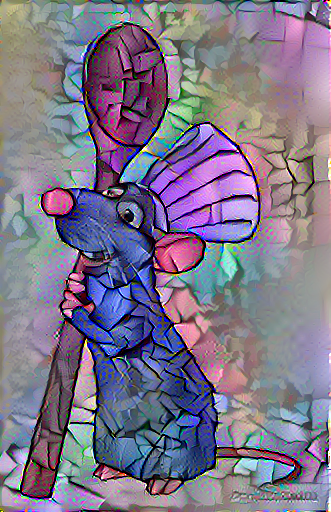

Train step: 1000
Total time: 66.2


In [35]:
import time  # Importing the time module to measure execution time

start = time.time()  # Record the start time

epochs = 10  # Number of training epochs
steps_per_epoch = 100  # Number of steps per epoch

step = 0  # Initialize step counter
for n in range(epochs):  # Loop through epochs
    for m in range(steps_per_epoch):  # Loop through steps in each epoch
        step += 1  # Increment step counter
        train_step(image)  # Perform a training step
        print(".", end='', flush=True)  # Print progress indicator

    display.clear_output(wait=True)  # Clear previous output
    display.display(tensor_to_image(image))  # Display the current state of the image
    print("Train step: {}".format(step))  # Print current step number

end = time.time()  # Record end time
print("Total time: {:.1f}".format(end-start))  # Print total execution time


# Saving Final Output

In [36]:
# Define the filename for saving the generated image
file_name = 'stylized-image.png'

# Convert the generated tensor image to a PIL image and save it
tensor_to_image(image).save(file_name)

# Attempt to download the saved image if running in Google Colab
try:
    from google.colab import files
    files.download(file_name)  # Download the file to the local system
except (ImportError, AttributeError):
    pass  # Skip if not running in Google Colab

# Load the saved image before displaying
generated_image = plt.imread(file_name)  # Read the saved image as an array for display


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizing Results

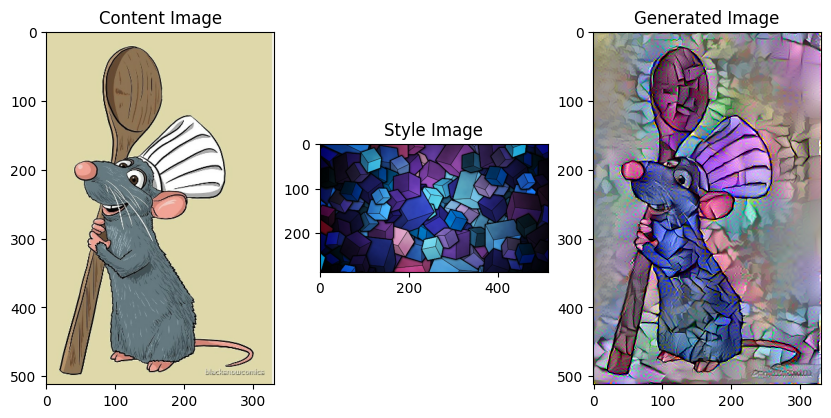

In [37]:
# Display the final result
plt.figure(figsize=(10, 5))  # Set the figure size for better visualization

# Display the content image
plt.subplot(1, 3, 1)  # Create a subplot in a 1x3 grid (1st position)
imshow(content_image, "Content Image")  # Show the original content image

# Display the style image
plt.subplot(1, 3, 2)  # Create a subplot in a 1x3 grid (2nd position)
imshow(style_image, "Style Image")  # Show the reference style image

# Display the generated image after style transfer
plt.subplot(1, 3, 3)  # Create a subplot in a 1x3 grid (3rd position)
imshow(generated_image, "Generated Image")  # Show the stylized output image

# Show all the images together
plt.show()  # Render the final visualization
